<a href="https://colab.research.google.com/github/tlmakinen/imnn/blob/0.2a5/IMNN_shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set up environment
!git clone https://github.com/tlmakinen/imnn.git

Cloning into 'imnn'...
remote: Enumerating objects: 862, done.
remote: Counting objects: 100% (862/862), done.
remote: Compressing objects: 100% (447/447), done.
remote: Total 862 (delta 389), reused 862 (delta 389), pack-reused 0
Receiving objects: 100% (862/862), 55.57 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (389/389), done.


In [ ]:
cd imnn/examples/

/content/imnn/examples


In [ ]:
!pip install IMNN

In [ ]:
!pip install numpyro

     |████████████████████████████████| 163kB 5.9MB/s 
     |████████████████████████████████| 419kB 11.2MB/s 
     |████████████████████████████████| 32.6MB 92kB/s 
  Created wheel for jax: filename=jax-0.1.73-cp36-none-any.whl size=477473 sha256=bc2b36ecb423f90a070542f0891c0ac522b1303c99dfcafe9229270858f08b6d
  Stored in directory: /root/.cache/pip/wheels/ac/27/58/dce04c2f08ba4d4bebdb474c35359f6540ceaffb021855a6f0
Successfully built jax
  Found existing installation: jax 0.1.75
    Uninstalling jax-0.1.75:
      Successfully uninstalled jax-0.1.75
  Found existing installation: jaxlib 0.1.52
    Uninstalling jaxlib-0.1.52:
      Successfully uninstalled jaxlib-0.1.52


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
from IMNN import IMNN
from IMNN.LFI import LFI
from make_edge_data import GenerateGaussianNoise
from make_edge_data import AnalyticLikelihood
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfd = tfp.distributions



# for autograd functions
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax.scipy.special as jspecial

import numpyro
import numpyro
import numpyro.distributions as dist

key = random.PRNGKey(0)


print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__))

IMNN 0.2a5
TensorFlow 2.3.0
TensorFlow Probability 0.11.0
numpy 1.18.5


# IMNN toy model
Let's try to find a toy problem in which methods like the linear MOPED method fails to recover accurate fiducial parameters, and the IMNN (perhaps) succeeds. We're going to start with generating data on an $N$-dimensional spherical shell. The goal of the exercise will be, given sampled data $\{(x_1, x_2, \dots x_N) \}_i$, with $i = 1, \dots n_d$, we want to recover the fiducial angle in spherical coordinates $\phi$, e.g. $\vec{\theta}_{\rm fid} = (r, \theta, \phi)_{\rm fid}$. Let's get started by coming up with a simulator for the situation.

In [ ]:
# θ_fid ~ {r, θ, \phi, \sigma_θ} = {1., \pi, 2\pi, 0.1}
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IMNN.utils import TFRecords
from IMNN.LFI.LFI import GaussianApproximation

__version__ = "0.2a5"
__author__ = "Lucas Makinen"

class GenerateShellData():
    def __init__(self, input_shape=(60,), n_params=2, n_summaries=2, n_s=1000, n_d=1000, n_d_small=100,
                 θ_fid=np.array([1., np.pi / 2, 2*np.pi, 0.1]), δθ=np.array([0.1, 0.1, 0.1, 0.1]), training_seed=0,
                 validation_seed=1):
        self.input_shape = input_shape
        self.coord_input_shape = (input_shape[0] // 3,)
        self.n_params = n_params
        self.n_summaries = n_summaries
        self.n_s = n_s
        self.n_d = n_d
        self.n_d_small = n_d_small
        self.θ_fid = θ_fid
        self.δθ = δθ
        self.half_δθ = δθ / 2.
        self.training_seed = training_seed
        self.validation_seed = validation_seed

    def get_fiducial(self, seed, data):
        return data[seed]

    def get_derivative(self, seed, derivative, parameter, data):
        return data[seed, derivative, parameter]

    def check_selection(self, size):
        if size not in ["full", "all", "small"]:
            print("size must be `full`, `all` or `small` describing, respectively "
                  "whether just `n_d=n_s` is returned, or `n_d=n_s` and `n_d_small` "
                  "is returned, or `n_d=n_d_small` is returned.")
            sys.exit()
    
    def check_ftype(self, ftype):
        if ftype not in ["both", "numpy", "tfrecords"]:
            print("size must be `both`, `numpy` or `tfrecords` describing, respectively "
                  "whether both `numpy` and `tfrecords` files are saved, or just either one.")
            sys.exit()

    def angToCart(self, r, theta, phi):
        return np.array([r*np.cos(theta)*np.sin(phi), 
                         r*np.sin(theta)*np.sin(phi), 
                         r*np.cos(phi)])

    def simulator(self, parameters, seed=None, simulator_args=None):
        # if self.input_shape[0] // 3 != 0:
        #     raise AssertionError ("input shape must be divisible by coordinate dimensions !")
        if seed is not None:
            np.random.seed(seed)
        if len(parameters.shape) == 1:
            parameters = parameters[np.newaxis, :]
        if self.n_params == 1:
            parameters = np.repeat(parameters, 2, axis=1)
            parameters[:, 0] = np.zeros_like(parameters[:, 0])
        
        r = np.ones(self.coord_input_shape + (parameters.shape[0],))*parameters[:, 0]

        #print(parameters.shape)

        phi = np.random.uniform(low=0., high=2*np.pi, size=self.coord_input_shape 
                                + (parameters.shape[0],))
        theta = np.random.normal(parameters[:, 1], np.sqrt(parameters[:, 3]), 
                                 size=self.coord_input_shape + (parameters.shape[0],))
        
        d = np.zeros((self.input_shape[0],) + (parameters.shape[0],))
        x,y,z = self.angToCart(r, theta, phi)
        d[0::3, :] = x
        d[1::3, :] = y
        d[2::3, :] = z

        return np.moveaxis(d,
                  -1, 0)

    def generate_data(self, size="full"):
          self.check_selection(size)
          details = dict(
              input_shape=self.input_shape,
              n_params=self.n_params,
              n_summaries=self.n_summaries,
              n_s=self.n_s,
              n_d=self.n_d,
              θ_fid=self.θ_fid,
              δθ=self.δθ)
          
          # training base sims
          a_0 = self.simulator(
              parameters=np.repeat(
                  self.θ_fid[np.newaxis, :], 
                  self.n_s, 
                  axis=0),
              seed=self.training_seed,
              simulator_args={"input_shape": self.input_shape})
          # validation base sims
          a_1 = self.simulator(
              parameters=np.repeat(
                  self.θ_fid[np.newaxis, :], 
                  self.n_s, 
                  axis=0),
              seed=self.validation_seed,
              simulator_args={"input_shape": self.input_shape})
          
          # FOR NOW: TWO parameters: ONLY vary theta and sigma2_theta
          # training -theta
          b_0 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1] - self.half_δθ[0],
                      self.θ_fid[2],
                      self.θ_fid[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.training_seed,
              simulator_args={"input_shape": self.input_shape})
          # validation -theta
          b_1 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1] - self.half_δθ[1],
                      self.θ_fid[2],
                      self.θ_fid[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.validation_seed,
              simulator_args={"input_shape": self.input_shape})    
          # training +theta  
          c_0 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1] + self.half_δθ[1],
                      self.θ_fid[2],
                      self.θ_fid[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.training_seed,
              simulator_args={"input_shape": self.input_shape})
          # validation +theta
          c_1 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1] + self.half_δθ[1],
                      self.θ_fid[2],
                      self.θ_fid[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.validation_seed,
              simulator_args={"input_shape": self.input_shape})
          # training -sigma2theta
          d_0 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1],
                      self.θ_fid[2],
                      self.θ_fid[3] - self.half_δθ[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.training_seed,
              simulator_args={"input_shape": self.input_shape})
          # validation -sigma2theta
          d_1 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1],
                      self.θ_fid[2],
                      self.θ_fid[3] - self.half_δθ[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.validation_seed,
              simulator_args={"input_shape": self.input_shape})  
          # training +sigma2theta     
          e_0 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1],
                      self.θ_fid[2],
                      self.θ_fid[3] + self.half_δθ[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.training_seed,
              simulator_args={"input_shape": self.input_shape})
          # validation +sigma2theta
          e_1 = self.simulator(
              parameters=np.repeat(
                  np.array([
                      self.θ_fid[0], 
                      self.θ_fid[1],
                      self.θ_fid[2],
                      self.θ_fid[3] + self.half_δθ[3],
                      ])[np.newaxis, :], 
                  self.n_d, 
                  axis=0),
              seed=self.validation_seed,
              simulator_args={"input_shape": self.input_shape}) 
          
          print('b0 shape : ', b_0.shape)
          f_0 = np.stack((np.stack((b_0, c_0)), 
                          np.stack((d_0, e_0)))
                        ).transpose(2, 1, 0, 3)
          f_1 = np.stack((np.stack((b_1, c_1)), 
                          np.stack((d_1, e_1)))
                        ).transpose(2, 1, 0, 3)

          result = (details, a_0, a_1, f_0, f_1)
          
          if size == "all":
              details["n_d_small"] = self.n_d_small
              result += (f_0[:self.n_d_small],
                        f_1[:self.n_d_small])
          elif size == "small":
              details["n_d"] = self.n_d_small
              result[-2] = f_0[:self.n_d_small]
              result[-1] = f_1[:self.n_d_small]
            
          return result
    
    def save(self, ftype="both", size="full", directory="data", record_size=0.01):
        self.check_ftype(ftype)
        result = self.generate_data(size=size)
        
        if (ftype=="both") or (ftype=="numpy"):
            np.savez("{}/details.npz".format(directory), result[0])
            np.save("{}/fiducial.npy".format(directory), result[1])
            np.save("{}/validation_fiducial.npy".format(directory), result[2])    
            np.save("{}/derivative.npy".format(directory), result[3])
            np.save("{}/validation_derivative.npy".format(directory), result[4])
            if size == "all":
                np.save("{}/derivative_small.npy".format(directory), result[5])
                np.save("{}/validation_derivative_small.npy".format(directory), result[6])

        if (ftype=="both") or (ftype=="tfrecords"):
            writer = TFRecords.TFRecords(record_size=record_size)
            
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[1]),
                fiducial=True, 
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[2]),
                fiducial=True, 
                validation=True,
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[3]),
                fiducial=False,
                n_params=result[0]["n_params"],
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[4]),
                fiducial=False,
                n_params=result[0]["n_params"],
                validation=True,
                directory="{}/tfrecords".format(directory))
            if size == "all":
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[5]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[6]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                
    def plot_data(self, data, ax=None, label=None, 
                  viewang1=20, viewang2=40):

        fig = plt.figure(figsize = (5, 4))
        ax = fig.add_subplot(111, projection='3d')
        print(data.T.shape)
        xs,ys,zs = data.T[::3], data.T[1::3], data.T[2::3]
        ax.scatter(xs, ys, zs, zdir='z', s=20, c=None, depthshade=True)
        
        ax.legend(frameon=False)
        # ax.set_xticks([])
        # ax.set_zticks([])
        ax.set_xlabel("x");
        ax.set_ylabel("y");
        ax.set_zlabel("z");


        # rotate the axes
        ax.view_init(viewang1, viewang2)
        ax.set_zlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlim(-1, 1)

        return fig,ax # for further modification


Let's take a look at a single simulation of our data:

(120, 1)


(<Figure size 360x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f607bd77358>)

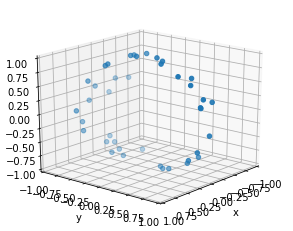

In [ ]:
generator = GenerateShellData(input_shape=(120,))

θ_target = np.array([1., np.pi/2., 2*np.pi, 0.1])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

Now that we've constructed our simulator, let's generate a set of data with noisy $\theta$ parameter, draw $\phi$ uniformly at random, and fix $r$. This dataset will correspond to a ring of fixed radius on a 3D sphere. We'll visualize it below.

In [ ]:
# define fiducial parameters and create data vector, d
θ_fid = np.array([1.0, np.pi / 2, 2*np.pi, 0.01]) # r, theta, phi, sigma^2_theta

In [ ]:
SN = GenerateShellData(n_s=10000, n_d=10000, input_shape=(60,))
details, fiducial, validation_fiducial, derivative, validation_derivative = SN.generate_data()

b0 shape :  (10000, 60)


In [ ]:
print("fiducial = {}\nvalidation_fiducial = {}\nderivative = {}\nvalidation_derivative = {}".format(
    fiducial.shape, validation_fiducial.shape, derivative.shape, validation_derivative.shape))

fiducial = (10000, 60)
validation_fiducial = (10000, 60)
derivative = (10000, 2, 2, 60)
validation_derivative = (10000, 2, 2, 60)


Now le but: We want to know firstly how well IMNN can tackle this problem, given a fiducial model to train on. Goals for right now:


1.   Train IMNN on fiducial parameters (set $\phi_{\rm fid} = \frac{\pi}{2}$ for now)
2.   Compare to MOPED algorithm



In [ ]:
def fiducial_loader(seed, data):
    yield data[seed], seed

def derivative_loader(seed, derivative, parameter, data):
    yield data[seed, derivative, parameter], (seed, derivative, parameter)

In [ ]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=SN.input_shape),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(SN.n_summaries)
     #tf.keras.layers.Conv1D(1,2),
     #tf.keras.layers.Reshape((2,))
    ])
opt = tf.keras.optimizers.Adam()

In [ ]:
imnn = IMNN.IMNN(n_s=SN.n_s, n_d=SN.n_d, n_params=SN.n_params, n_summaries=SN.n_summaries,
                 model=model, optimiser=opt, θ_fid=np.array([np.pi / 2, 0.1]), δθ=np.array([0.1,0.1]), input_shape=SN.input_shape,
                 fiducial=lambda x : fiducial_loader(x, fiducial), 
                 derivative=lambda x, y, z : derivative_loader(x, y, z, derivative), 
                 validation_fiducial=lambda x : fiducial_loader(x, validation_fiducial),
                 validation_derivative=lambda x, y, z : derivative_loader(x, y, z, validation_derivative), 
                 at_once=SN.n_s, check_shape=True, verbose=True,
                 directory="model", filename="model", save=True)

input shape will be (60,)
saving model to model/model
INFO:tensorflow:Assets written to: model/model/assets


INFO:tensorflow:Assets written to: model/model/assets


In [ ]:
imnn.fit(patience=10, min_iterations=1000)

ValueError: ignored

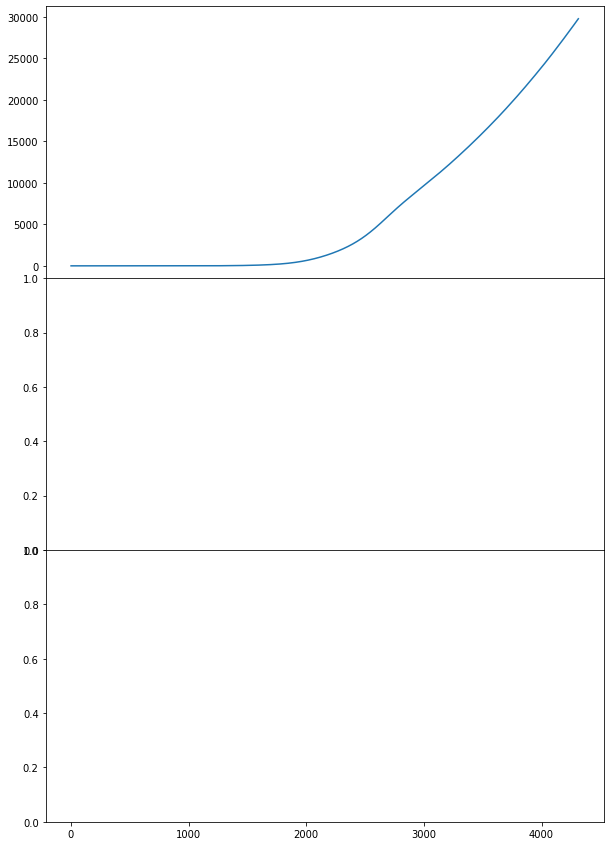

In [ ]:
imnn.plot(known_det_fisher=1.37e6)

(60, 1)


(<Figure size 360x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f5fff315198>)

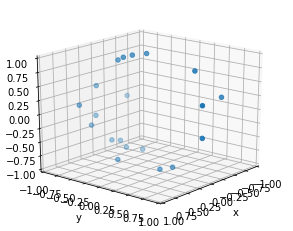

In [ ]:
generator = GenerateShellData(input_shape=(60,))

θ_target = np.array([1., np.pi/2., 2*np.pi, 0.1])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

In [ ]:
prior = tfd.Blockwise([tfd.Uniform(-10., 10.),
                       tfd.Uniform(0.1, 10.)])

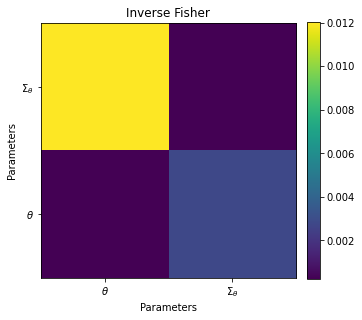

In [ ]:
GA = LFI.GaussianApproximation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

GA.plot_Fisher(figsize=(5, 5));


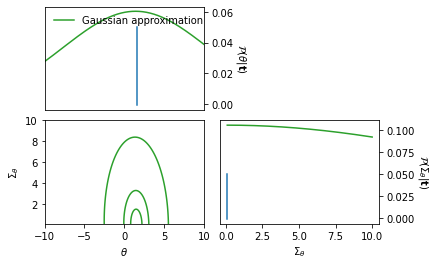

In [ ]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");

ax[0][0].plot(np.ones(10)*np.pi/2, np.linspace(-0.001,0.05, 10))
#ax[0][1].plot(np.ones(10)*np.pi/2, np.linspace(-0.001,0.05, 10))
ax[1][1].plot(np.ones(10)*0.1, np.linspace(-0.001,0.05, 10))

In [ ]:
# run ABC computation
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=SN.simulator,
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

InvalidArgumentError: ignored

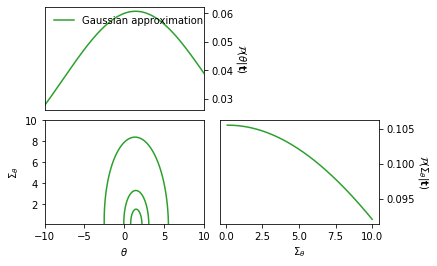

In [ ]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ϵ=1.,
    accepted=2000,
    draws=10000,
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(1),
    smoothing=0,
    bins=50);